### Part 2:  Pose Graph Optimization for 2D SLAM

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

In [3]:
# Import
import os
import numpy as np
import math
import matplotlib.pyplot as plt

# from g2o_fhdlr.read_se2 import read_vertex, read_edges_olc
# from g2o_fhdlr.write_se2 import write_vertex
import gtsam

import jax.numpy as jnp
from jax import jacfwd

### Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [5]:
# Helper Function

def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()

In [15]:

def readvertex(line):
    _, _, x, y, theta = line.strip().split()
    return float(x), float(y), float(theta)

def readedge(line):
    _, i, j, x, y, theta, sigma_x, _, _, sigma_y, _, sigma_theta = line.strip().split()
    return int(i), int(j), float(x), float(y), float(theta), float(sigma_x), float(sigma_y), float(sigma_theta)

def read_g2o(filename, after_fix=False):
    with open(filename, 'r') as f:
        lines = f.readlines()

    ver_x, ver_y, ver_theta = [], [], []
    edge_i, edge_j = [], []
    edge_x, edge_y, edge_theta = [], [], []
    info_x, info_y, info_theta = [], [], []

    read = not after_fix

    for line in lines:
        if "VERTEX_SE2" in line and read:
            x, y, theta = readvertex(line)
            ver_x.append(x)
            ver_y.append(y)
            ver_theta.append(theta)

        elif "EDGE_SE2" in line and read:
            i, j, x, y, theta, sigma_x, sigma_y, sigma_theta = readedge(line)
            edge_i.append(i)
            edge_j.append(j)
            edge_x.append(x)
            edge_y.append(y)
            edge_theta.append(theta)
            info_x.append(sigma_x)
            info_y.append(sigma_y)
            info_theta.append(sigma_theta)

        elif "FIX 0" in line:
            read = not read

    vertex = np.array([ver_x, ver_y, ver_theta])
    edge = np.array([edge_i, edge_j, edge_x, edge_y, edge_theta, info_x, info_y, info_theta])

    return vertex, edge

def next_pose(x, y, theta, index, edge):
    x = x + (edge[2][index]*np.cos(theta)) - (edge[3][index]*np.sin(theta))
    y = y + (edge[3][index]*np.cos(theta)) + (edge[2][index]*np.sin(theta))
    theta = theta + edge[4][index]
    return x, y, theta

def motion_model(vertex, edge):
    X, Y, THETA = [], [], []
    
    x, y, theta = vertex.tolist()
    
    X.extend(x), Y.extend(y), THETA.extend(theta)
    
    for index in range(edge.shape[-1]):
        x, y, theta = next_pose(x, y, theta, index, edge)
        
        X.extend(x), Y.extend(y), THETA.extend(theta)
    return X, Y, THETA
def write_g2o(filename, vertex, edge, postfix_vertex, postfix_edge):
    
    X, Y, THETA = motion_model(vertex, edge)
    
    g2o = open(filename,'w')
    for index, (x, y, theta) in enumerate(zip(X,Y,THETA)):
        line = f'VERTEX_SE2 {index} {x} {y} {theta}'
        g2o.write(line)
        g2o.write("\n")
    
    for index in range(edge.shape[-1]):
        line = f'EDGE_SE2 {int(edge[0][index])} {int(edge[1][index])} {edge[2][index]} {edge[3][index]} {edge[4][index]} {edge[5][index]} 0.0 0.0 {edge[6][index]} 0.0 {edge[7][index]}'
        g2o.write(line)
        g2o.write("\n")
        
    g2o.write("FIX 0\n")
    
    for index in range(postfix_edge.shape[-1]):
        line = f'EDGE_SE2 {int(postfix_edge[0][index])} {int(postfix_edge[1][index])} {postfix_edge[2][index]} {postfix_edge[3][index]} {postfix_edge[4][index]} {postfix_edge[5][index]} 0.0 0.0 {postfix_edge[6][index]} 0.0 {postfix_edge[7][index]}'
        g2o.write(line)
        g2o.write("\n")
        
    # print(f"{filename} saved successfully!!")

Initial Pose


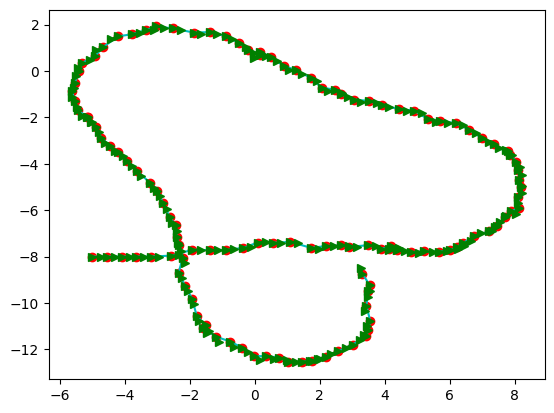

In [16]:
measurement_data = "./../data/edges.txt"
vertex, edge = read_g2o(measurement_data)
postfix_vertex, postfix_edge = read_g2o(measurement_data, after_fix=True)

write_g2o('../data/edges-poses.g2o', vertex, edge, postfix_vertex, postfix_edge)

X, Y, THETA = motion_model(vertex, edge)

print("Initial Pose")
draw(X, Y, THETA)

### Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this assignment. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

Iteration: 0, Error: 649982.8209620635


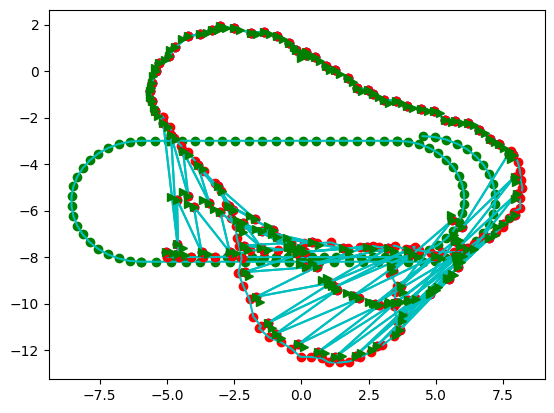

Iteration: 1, Error: 2239.4378959062915


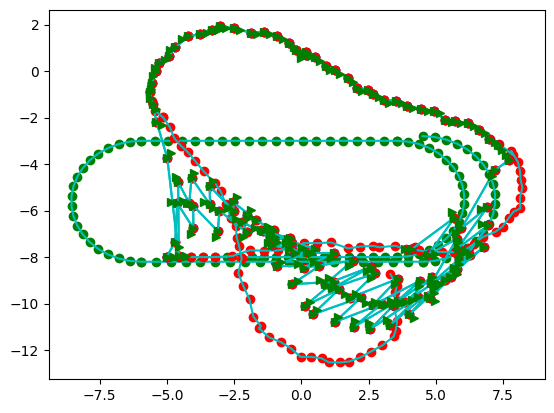

Iteration: 2, Error: 466.8509268293154


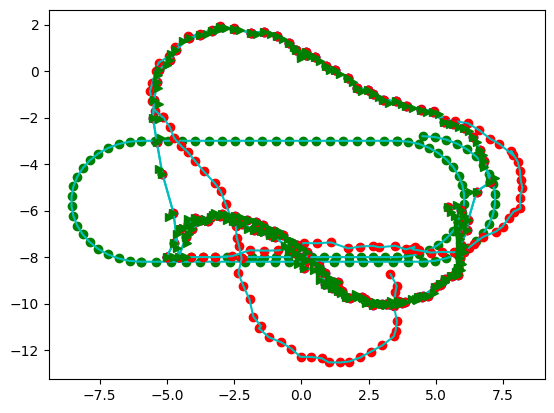

Iteration: 3, Error: 37.58879221278656


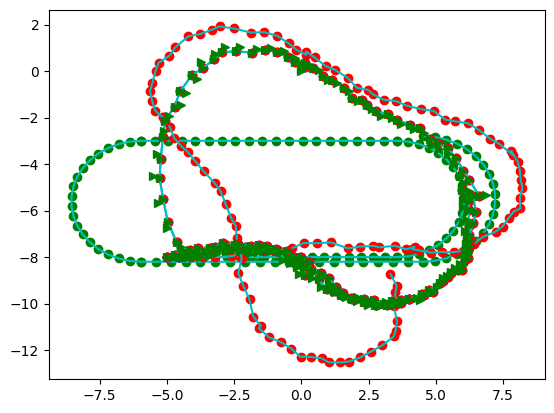

Iteration: 4, Error: 13.48206305305854


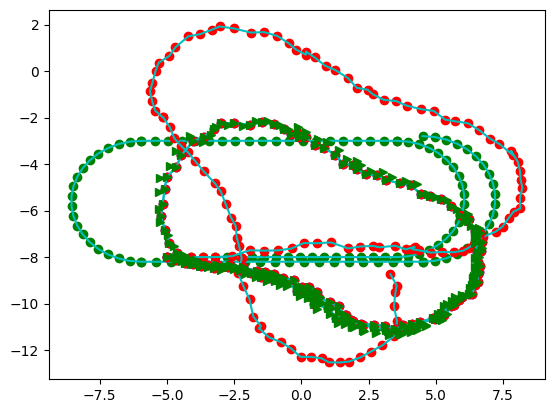

Iteration: 5, Error: 6.580058030330184


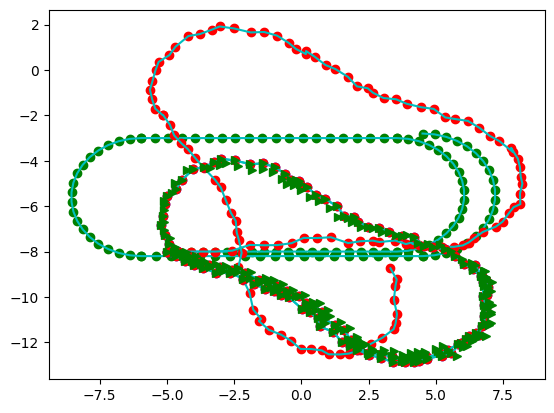

Iteration: 6, Error: 4.9254973005291305


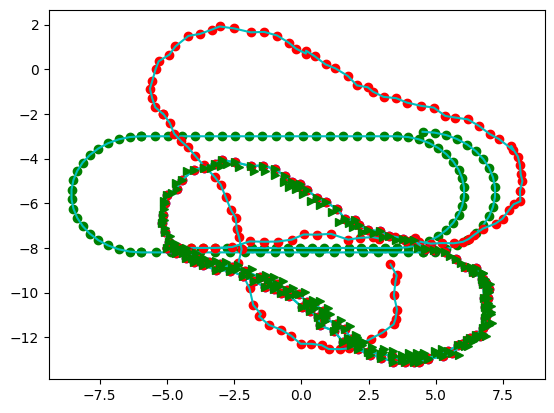

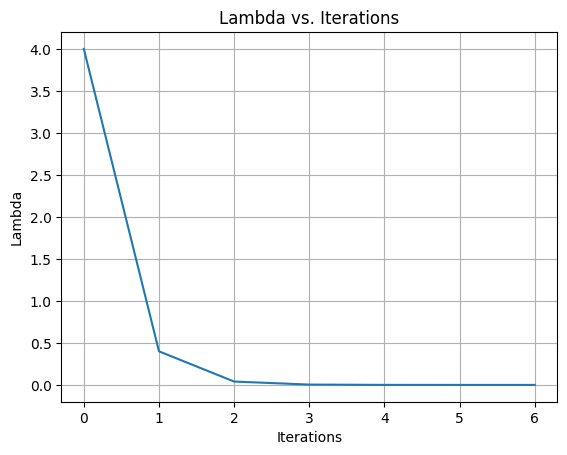

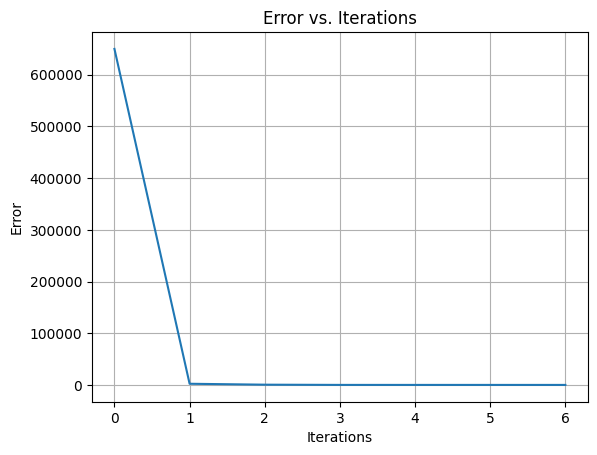

In [24]:
def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")


def X_pose(vertex,edge):
    delta_x, delta_y, delta_theta = [], [], []
    num_pose = vertex.shape[-1]
    for index in range(num_pose):
        delta_x.append(edge[2][index]*np.cos(vertex[2][index]) - edge[3][index]*np.sin(vertex[2][index]))
        delta_y.append(edge[3][index]*np.cos(vertex[2][index]) + edge[2][index]*np.sin(vertex[2][index]))
        delta_theta.append(edge[4][index])
    U = np.array([delta_x, delta_y, delta_theta])
    # U = np.ravel(U)
    U = U.flatten()
    
    # X = np.ravel(vertex)
    X = vertex.flatten()
    return X, U


def info_matrix(edge, INFO_OD, INFO_LOOP, INFO_WORLD):
    diag = []
    for index in range(edge[:2, :].shape[-1]):
        i, j = edge[0][index], edge[1][index]
        if i+1 == j:
            diag.extend([INFO_OD]*3)
        else:
            diag.extend([INFO_LOOP]*3)
    diag.extend([INFO_WORLD]*3)
    return np.diag(diag)



def get_residual(X, U, edge, num_poses):
    
    f_x = []
    for index in range(edge.shape[-1]):
        i, j = int(edge[0][index]), int(edge[1][index])
        f_x.append(X[i] + U[i] - X[j])
        f_x.append(X[i+num_poses] + U[i+num_poses] - X[j+num_poses])
        f_x.append(X[i+2*num_poses] + U[i+2*num_poses] - X[j+2*num_poses])

    f_x.append(X[0] + 5)
    f_x.append(X[num_poses] + 8)
    f_x.append(X[2*num_poses] - 0)
 
    return np.array(f_x)
    
def get_jacobian(X, U, edge, num_poses):
    f_x = get_residual(X, U, edge, num_poses)
    
    h = 0.001

    jacobian = []
    for i, param in enumerate(X):
        X_ = X.copy()
        X_[i] += h
        f_x_h = get_residual(X_, U, edge, num_poses)
        partial_derv = (f_x_h - f_x) / h
        jacobian.append(partial_derv)
    jacobian = np.array(jacobian).T

    return jacobian

def get_individual_poses(X, num_poses):
    
    assert len(X.shape) == 1
    
    x = X[0:num_poses]
    y = X[num_poses:2*num_poses]
    theta = X[2*num_poses:]
    
    return x, y, theta

def plot_trajectories(X, num_poses):
    vertex_gt, _ = read_g2o("../data/gt.txt")
    x_gt, y_gt, theta_gt = vertex_gt[0], vertex_gt[1], vertex_gt[2]
    
    vertex_init, _ = read_g2o("../data/edges-poses.g2o")
    x_init, y_init, theta_init = vertex_init[0], vertex_init[1], vertex_init[2]
    
    x, y, theta = get_individual_poses(X, num_poses)
    
    ax = plt.subplot(111)
    
    ax.plot(x_gt, y_gt, 'go',label = 'Ground Truth Pose')
    plt.plot(x_gt, y_gt, 'c-')
    
    ax.plot(x_init, y_init, 'ro', label = 'Initial Pose')
    plt.plot(x_init, y_init, 'c-')
    
    ax.plot(x,y,'bo',label = 'Optimized Pose')
    plt.plot(x, y, 'c-')

    draw(x,y,theta)
   
def lm(filename, LAMBDA=40, MAX_ITR=3, INFO_OD=2, INFO_LOOP=700, INFO_WORLD=1000):
    vertex, edge = read_g2o(filename)
    
    _, postfix_edge = read_g2o(filename, after_fix=True)
    
    num_poses = vertex.shape[-1]
    
    edge = np.concatenate((edge, postfix_edge), axis=1)
    
    X, U = X_pose(vertex, edge)
    
    sigma = info_matrix(edge, INFO_OD, INFO_LOOP, INFO_WORLD)
    
    prev_error = 10**9

    # Lists to store values for plotting
    errors = []
    lambdas = []


    for ITR in range(MAX_ITR):
        R = get_residual(X, U, edge, num_poses)
        J = get_jacobian(X, U, edge, num_poses)
        
        H = J.T @ sigma @ J
        I = LAMBDA * np.eye(H.shape[0])
        
        delta = np.linalg.inv(H + I) @ J.T @ sigma.T @ R
        
        error = (R.T @ sigma @ R) / 2
        
        if prev_error > error:
            X -= delta
            LAMBDA /= 10
        else:
            LAMBDA *= 10
        
        prev_error = error

        # Append values for plotting
        errors.append(error)
        lambdas.append(LAMBDA)

        print(f"Iteration: {ITR}, Error: {error}")
        plot_trajectories(X, num_poses)
        
        if error < 5:
            break

    # Create plots
    plt.figure()
    plt.plot(range(MAX_ITR), lambdas)
    plt.xlabel('Iterations')
    plt.ylabel('Lambda')
    plt.title('Lambda vs. Iterations')
    plt.grid()

    plt.figure()
    plt.plot(range(MAX_ITR), errors)
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs. Iterations')
    plt.grid()
    plt.show()

    x, y, theta = get_individual_poses(X, num_poses)
    return x, y, theta

X_final, Y_final, THETA_final = lm("../data/edges-poses.g2o", MAX_ITR=7)


### Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Residual Vector
Residual Vector is the constraints based on motion model. Residual functions are used for calculating the difference between the observed pose and pose computed by applying the motion model.Each constraint has is three equations for x,y,theta each. It is a one dimensional vector, and has dimension equal to dimension of poses (x,y,theta) multiplied by the number of odometery and loop closure constraints.

In the above case
- Odometry Constraints = 119
- Loop Closure Constraints = 20
- Zero Start Constraint = 1
- No. of equations = 3 x (119 + 20 + 1) = 420 equations

Therefore, length of the residual vector is 420. (in matrix form 420 x 1)

## Jacobian Matrix
The jacobian matrix is calculated by finding the derivative of the residual vector with respect to each state x.

$$ J = \frac{\partial \mathbf{v}}{\partial \mathbf{x}} $$

The Jacobian is essentially a 3 x 3 matrix. It can be expressed as:

$$ J_l,m = \frac{\partial \mathbf{v_l}}{\partial \mathbf{x_m}} $$

The shape of the matrix is thus, 
$$(3 * v * (od + lc))\times (3 * v * od)$$

where 
- v = number of vertices
- od = odometry constriants
- lc = loop closure constraints

## Optimization Process

The Levenberg-Marquardt (LM) Algorithm was used to optimize the error funciton. the pose is updated iteratively as follows:

$$\delta(x)  = -(J^T.Ω.J + \lambda I)^{-1}.J^T.Ω^T.v$$

$\lambda$ is a damping parameter and I is the identity matrix. Usually when there is sufficient reduction in the loss value, the value of the damping factor is reduced, else it is increased.

The information matrix is given by :
$$A = J^T.Ω.J + \lambda I$$

Higher importance is given to the loop closure constraints when compared to odometry constraints.

The intermediate plots have been shown above.


### Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.

In [19]:
def save(filename,X,Y, THETA):
    X = np.around(X,4)
    Y = np.around(Y,4)
    THETA = np.around(THETA,4)

    g2o = open(filename, "w")
    for index, (x, y, theta) in enumerate(zip(X, Y, THETA)):
        line = f"VERTEX_SE2 {index} {x} {y} {theta}"
        g2o.write(line)
        g2o.write("\n")

    g2o.write("FIX 0\n")


save('../data/final_traj.g2o',X_final,Y_final,THETA_final)